In [1]:
# Results w.r.t. different properties of the molecule

import pickle as pkl
import numpy as np
import matplotlib
#matplotlib.rcParams.update({'font.size': 40})
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import pandas as pd
import os
import time
from collections import OrderedDict
from summary_utils import read_mols_baseline, read_mols_neuralnet
%matplotlib inline

In [2]:
dataset = 'QM9'
num_conformers = [100]
result_type = "min"
nn_hyperparams = ["prior_T=1"]

In [3]:
nn_mols = OrderedDict()
for nn_i in nn_hyperparams:
    nn_mols[nn_i] = read_mols_neuralnet('/home/mansimov/projects/dl4chem-geometry/results/nn/{}/{}/_test_'.format(nn_i, dataset), num_conformers)

done 0 out of 5000
done 500 out of 5000
done 1000 out of 5000
done 1500 out of 5000
done 2000 out of 5000
done 2500 out of 5000
done 3000 out of 5000
done 3500 out of 5000
done 4000 out of 5000
done 4500 out of 5000
time took 0.9275882244110107


In [4]:
nn_ff_mols = read_mols_baseline('/home/mansimov/projects/dl4chem-geometry/results/nn_ff/{}/_test_/rep_100_iter_200/mols'.format(dataset), num_conformers)

done 0 out of 2377
done 500 out of 2377
done 1000 out of 2377
done 1500 out of 2377
done 2000 out of 2377
time took 4.062881708145142


In [5]:
nn_dg_mols = read_mols_baseline('/home/mansimov/projects/dl4chem-geometry/results/nn_ff/{}/_test_/rep_100_iter_0/mols'.format(dataset), num_conformers)

done 0 out of 2558
done 500 out of 2558
done 1000 out of 2558
done 1500 out of 2558
done 2000 out of 2558
done 2500 out of 2558
time took 4.290606260299683


In [6]:
ff_mols = read_mols_baseline('/home/mansimov/projects/dl4chem-geometry/results/ff/{}/_test_/rep_100_iter_200/mols'.format(dataset), num_conformers)

done 0 out of 5000
done 500 out of 5000
done 1000 out of 5000
done 1500 out of 5000
done 2000 out of 5000
done 2500 out of 5000
done 3000 out of 5000
done 3500 out of 5000
done 4000 out of 5000
done 4500 out of 5000
time took 17.087188482284546


In [7]:
mols_summary = {}
mols_summary["method"] = []
mols_summary["results"] = []
mols_summary["num_conformers"] = []

avail_keys = []
for k in list(nn_ff_mols.keys()):
    if k in list(ff_mols.keys()) and k in list(nn_dg_mols.keys()):
        avail_keys.append(k)

for n_conf in num_conformers:
    min_mmff = [ff_mols[mol_num]['{}_mmff'.format(result_type)][n_conf] for mol_num in avail_keys]
    min_uff = [ff_mols[mol_num]['{}_uff'.format(result_type)][n_conf] for mol_num in avail_keys]
    
    mols_summary['method'] = mols_summary['method'] + ["MMFF"] * len(min_mmff) + ["UFF"] * len(min_uff)
    mols_summary['results'] = mols_summary['results'] + min_mmff + min_uff
    mols_summary['num_conformers'] = mols_summary['num_conformers'] + [n_conf] * len(min_uff + min_mmff)

    min_nn_mmff = [nn_ff_mols[mol_num]['{}_mmff'.format(result_type)][n_conf] for mol_num in avail_keys]
    min_nn_uff = [nn_ff_mols[mol_num]['{}_uff'.format(result_type)][n_conf] for mol_num in avail_keys]
    
    mols_summary['method'] = mols_summary['method'] + ["Neural Net + DG (MMFF)"] * len(min_nn_mmff) + ["Neural Net + DG (UFF)"] * len(min_nn_uff)
    mols_summary['results'] = mols_summary['results'] + min_nn_mmff + min_nn_uff
    mols_summary['num_conformers'] = mols_summary['num_conformers'] + [n_conf] * len(min_nn_mmff + min_nn_uff)

    min_nn_dg = [nn_dg_mols[mol_num]['{}_mmff'.format(result_type)][n_conf] for mol_num in avail_keys]
    
    mols_summary['method'] = mols_summary['method'] + ["Neural Net + DG"] * len(min_nn_dg)
    mols_summary['results'] = mols_summary['results'] + min_nn_dg
    mols_summary['num_conformers'] = mols_summary['num_conformers'] + [n_conf] * len(min_nn_dg)

    for nn_i in nn_hyperparams:
        nn_mol = nn_mols[nn_i]

        ### NOTE keep in mind that for neural net we only use molecule indicies for which MMFF and UFF baselines succeeded
        min_nn_rmsd = [nn_mol[mol_num]['{}_rmsd'.format(result_type)][n_conf] for mol_num in avail_keys]
        #min_nn_rmsd = [nn_mol[mol_num]['median_rmsd'][n_conf] for mol_num in ff_mols.keys()]

        #mols_summary['method'] = mols_summary['method'] + ["Neural Net {}".format(nn_i)] * len(min_nn_rmsd)
        mols_summary['method'] = mols_summary['method'] + ["Neural Net"] * len(min_nn_rmsd)
        mols_summary['results'] = mols_summary['results'] + min_nn_rmsd
        mols_summary['num_conformers'] = mols_summary['num_conformers'] + [n_conf] * len(min_nn_rmsd)

for k in mols_summary.keys():
    mols_summary[k] = np.array(mols_summary[k])

(8856,)
(8856,)
(8856,)


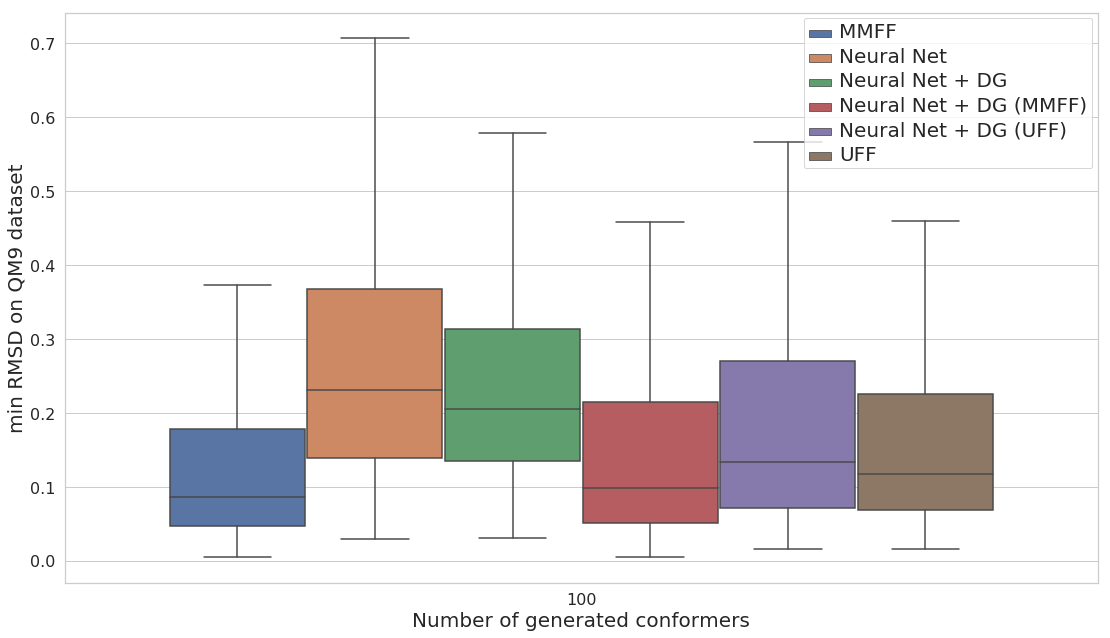

In [8]:
mols_summary["results"] = pd.Series(mols_summary["results"], dtype="float32")
mols_summary["method"] = pd.Series(mols_summary["method"], dtype="category")
mols_summary["num_conformers"] = pd.Series(mols_summary["num_conformers"], dtype="category")

print (mols_summary["results"].shape)
print (mols_summary["method"].shape)
print (mols_summary["num_conformers"].shape)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#ax = sns.boxplot(x="method", y="results", hue="num_conformers", data=ff_mols_summary)
ax = sns.boxplot(x="num_conformers", y="results", hue="method", data=mols_summary, showfliers=False)
ax.set_xlabel('Number of generated conformers', fontsize=20)
ax.set_ylabel('{} RMSD on {} dataset'.format(result_type, dataset), fontsize=20)
#ax.set_ylabel('Median RMSD on {} dataset'.format(dataset), fontsize=20)
plt.legend(loc='upper right')
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
ax.tick_params(labelsize=16)
